<h4 align='center'> Fundamentals of Machine Learning - 2022 </h4>
<h2 align='center'> Report 2 - Classifying with convnets </h2>
<h5 align='center'> Michel Romero Rodríguez </h5>



## 1. Introducción

### 1.1 Objetivos

Se trabajará con un *dataset* de imágenes:

>*The dataset is composed by 400 images of 40 different people, each image consisting of
64x64 pixels, each quantized to 256 grey levels and converted to floating point values on the
interval [0, 1]. The target for this database is an integer from 0 to 39 indicating the identity
of the person pictured.*

El problema que se plantea está dividido en dos partes:

> 1. *Build a baseline classification pipeline with a classic machine learning algorithm (i.e. not
based on a neural network) of your choosing, and estimate its classification error. There
should be efforts to improve this error as much as possible.*
> 2. *Build a convolutional neural network to classify the same dataset. There should be efforts
to improve its error over the baseline.*

### 1.2 Una vista a los datos

In [2]:
# Some basic imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import os

# Random Seed
np.random.seed(1234)

In [3]:
DATA_PATH = 'data/faces_dict.p'

Los datos están se encuentran en un `dict` de python guardados en un archivo `pickle`

In [4]:
with open(DATA_PATH, 'rb') as f:
    faces = pickle.load(f)
faces.keys()

dict_keys(['data', 'images', 'target'])

In [5]:
[faces[x].shape for x in faces]

[(400, 4096), (400, 64, 64), (400,)]

El diccionario tiene tres *keys*

- `'data'` contiene un arreglo de las imágenes *flattened*, cada una como un arreglo de una dimensión
- `'images'` contiene un arreglo de las imágenes representadas en forma de matriz de 64x64
- `'target'` contiene un arreglo con la clase correspondiente a cada una de las imágenes respectivamente

In [6]:
images = faces['images']
target = faces['target']

#### 1.2.1 Visualización de las imágenes

In [7]:
# Show a single image from the matrix
def show_face(face):
	plt.figure(figsize=(2, 2))
	plt.imshow(face, cmap='gray')
	plt.axis('off')
	plt.show()

# Show a list of faces
def show_faces(faces):
	plt.figure(figsize=(10, len(faces)))
	for index, face in enumerate(faces):
		plt.subplot(1, 10, index+1)
		plt.imshow(face, cmap='gray')
		plt.axis('off')
	plt.show()

Target: 0


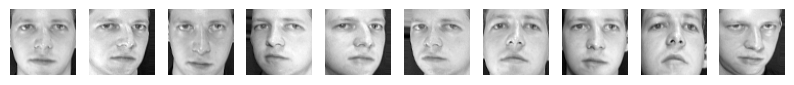

Target: 1


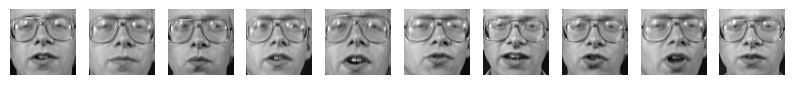

Target: 2


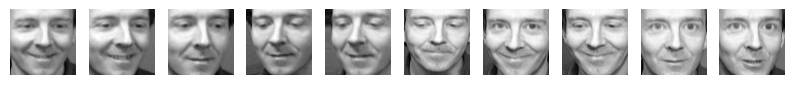

Target: 3


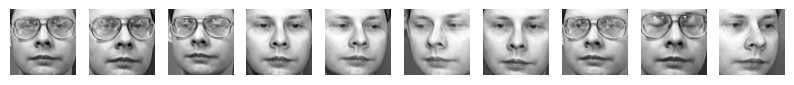

Target: 4


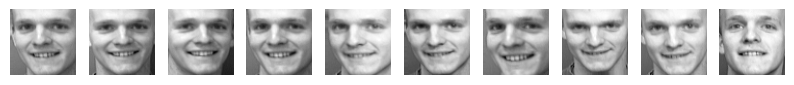

In [8]:
for i in range(5):
	print(f'Target: {i}')
	show_faces(images[i * 10: (i+1) * 10])

Un humano (al menos yo) puede identificar claramente que cada grupo corresponde a la misma persona. Presiento que los *targets* como el número 3 serán difíciles a la hora de realizar la clasificación al tener gafas en unas fotos y en otras no.

10 imágenes para cada persona son muy pocos datos como para obtener un buen modelo, así que corresponderá aplicar técnicas de *data augmentation*.

#### 1.2.2 Manipulando las imágenes

Tomaré una cada al azar (casi) para probar distintas manipulaciones para aumentar la cantidad de datos

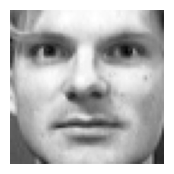

In [10]:
face = images[177] # Mi cumpleaños es el 17 de julio
show_face(face)

##### Rotación
Una primera transformación que se le puede hacer a las caras es rotarlas

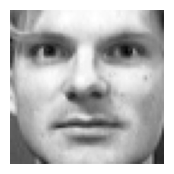

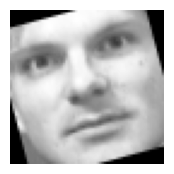

In [11]:
from skimage.transform import rotate
rot = rotate(face, 15)
show_face(face)
show_face(rot)

Una rotación de más de 15 grados me parece un cambio demasiado fuerte suponiendo que las imágenes a clasificar luego serían imágenes de caras relativamente derechas.

##### Inversión horizontal

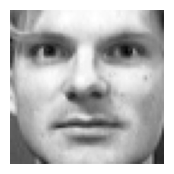

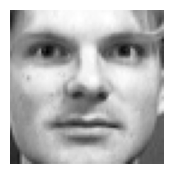

In [12]:
flpp = np.flip(face, axis=1)
show_face(face)
show_face(flpp)

Esta transformación es totalmente válida pues las caras suelen ser relativamente simétricas

##### Traslación



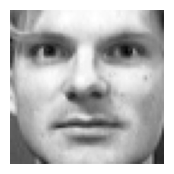

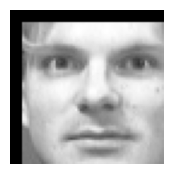

In [13]:
from skimage.transform import AffineTransform, warp

def shift(image, vector):
	transform = AffineTransform(translation=vector)
	shifted = warp(image, transform, mode='constant', preserve_range=True)
	return shifted

shifted = shift(face, (-5, -5))

show_face(face)
show_face(shifted)

Acá seré conservador y llegaré hasta 5 píxeles de traslación para evitar cortar partes importantes de las caras

##### Ruido

Por último se puede agregar ruido a las imágenes

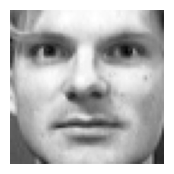

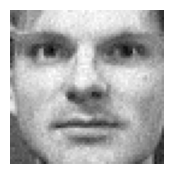

In [14]:
from skimage.util import random_noise
noisy = random_noise(face, seed=1, var=0.0005)
show_face(face)
show_face(noisy)

Esta imagen obtenida es totalmente reconocible, hasta ese valor de ruido se puede llegar.

##### Combinación

Se pueden combinar todos los métodos anteriores para obtener muchas más imágenes, $2^4 = 16$ si solo suponemos que se pueda usar o no usar cada uno de los anteriores para cada imagen. Incluso muchísimos más si usamos distintos ángulos de rotación y vectores de traslación.

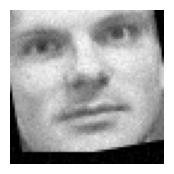

In [15]:
# Por ejemplo
new_face = random_noise(shift(rotate(np.flip(face, axis=1), 10), (0, 5)), seed=1, var=0.0005)
show_face(new_face)

In [16]:
from skimage.util import random_noise
from skimage.transform import rotate
from skimage.transform import AffineTransform, warp

def shift(image, vector):
	transform = AffineTransform(translation=vector)
	shifted = warp(image, transform, mode='constant', preserve_range=True)
	return shifted

class RandomTransform:
	'''
		Apply random transformation to data

	Attributes
	==========

	angle: float
		Max absolute angle of rotation in degrees 

	xshift: int
		Max absolute shift in the x direction

	yshift: int
		Max absolute shift in the y direction

	Methods
	=======

	__call__
		Applies a random transformation
	
	'''

	def __init__(self, angle, xshift, yshift):
		self.angle = angle
		self.xshift = xshift
		self.yshift = yshift

	def __call__(self, img):
		new_img = img

		# Randomly flip
		if np.random.random() > 0.5:
			new_img = np.flip(new_img, axis=1)

		# Random rotation
		new_img = rotate(new_img, (1 - 2 * np.random.random()) * self.angle)

		# Random shift
		new_img = shift(new_img, (
			np.random.randint(-self.xshift, self.xshift),
			np.random.randint(-self.yshift, self.yshift)
		))

		# Randomly apply noise
		if np.random.random() > 0.5:
			new_img = random_noise(new_img, seed=1234, var=0.0005)

		return new_img

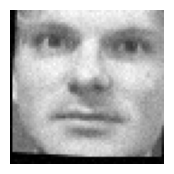

In [17]:
random_transform = RandomTransform(15, 5, 5)
new_face = random_transform(face)
show_face(new_face)

## 2. Preparación de los datos

### 2.1 Partición *trainig* / *test*

Primeramente separemos los datos en una partición de entrenamiento y otra de prueba, como los datos son pocos habrá que usar *stratified sampling* para asegurarnos de tener en la partición de entrenamiento representación de todas las clases.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, target, train_size=0.8, stratify=target, random_state=1234)

result = np.unique(Y_train, return_counts=True)
for u, c in zip(*result):
	print(f'{u}: {c}')

0: 8
1: 8
2: 8
3: 8
4: 8
5: 8
6: 8
7: 8
8: 8
9: 8
10: 8
11: 8
12: 8
13: 8
14: 8
15: 8
16: 8
17: 8
18: 8
19: 8
20: 8
21: 8
22: 8
23: 8
24: 8
25: 8
26: 8
27: 8
28: 8
29: 8
30: 8
31: 8
32: 8
33: 8
34: 8
35: 8
36: 8
37: 8
38: 8
39: 8


Ahora dividiré la partición de entrenamiento para obtener una partición de validación

In [19]:
X, X_val, Y, Y_val =  train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train, random_state=1234)

### 2.2 *Data augmentation*

A la partición de entrenamiento ahora le aplicaré el *data augmentation* con 10 transformaciones random para cada imagen.

In [20]:
# Transformación random
random_transform = RandomTransform(15, 5, 5)

X_aug = []
Y_aug = []

for x, y in zip(X, Y):
	X_aug.append(x)
	Y_aug.append(y)
	for i in range(9):
		X_aug.append(random_transform(x))
		Y_aug.append(y)

X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

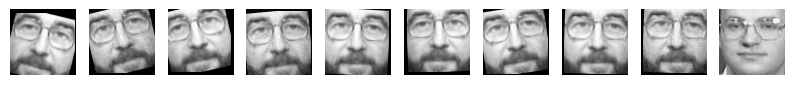

In [21]:
idx = np.random.randint(0, len(X_aug) - 10)
show_faces(X_aug[idx: idx+10])

### 2.4 Reducción de dimensionalidad

Para aumentar la velocidad del procesamiento realicemos reducción de dimensionalidad de la data utilizando PCA

In [22]:
from sklearn.decomposition import PCA

pca = PCA(0.99) # Mantener el 99% de la varianza

X_aug_pca = pca.fit(X_aug.reshape((-1, 4096)))
pca.n_components_

592

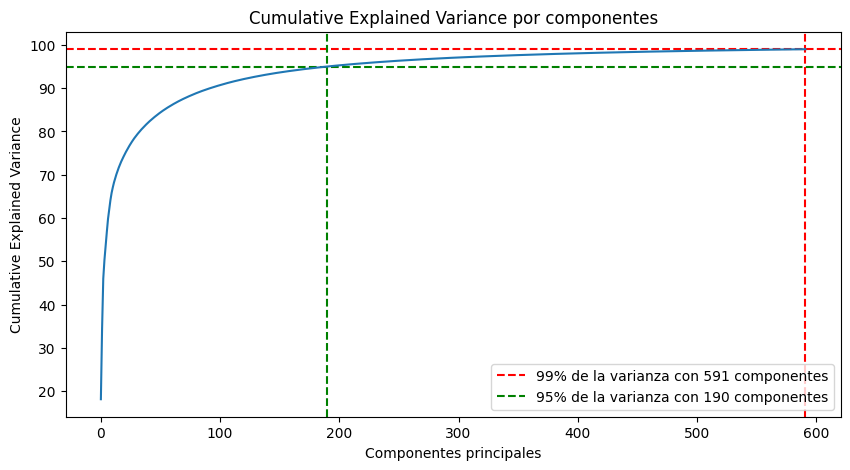

In [23]:
cum_var = np.cumsum(pca.explained_variance_ratio_) * 100
k99 = np.argmax(cum_var>99)
k95 = np.argmax(cum_var>95)

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance por componentes')
plt.xlabel("Componentes principales")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=99, color="r", linestyle="--", label=f'99% de la varianza con {k99} componentes')
plt.axvline(x=k99, color="r", linestyle="--")
plt.axhline(y=95, color="g", linestyle="--", label=f'95% de la varianza con {k95} componentes')
plt.axvline(x=k95, color="g", linestyle="--")
plt.plot(cum_var)
plt.legend()
plt.show()

Para quedarnos con un 99% de la varianza son necesarias cerca de 600 componentes principales, lo cual reduce la dimensión de la data por cerca de 7 veces; sin embargo, con formándonos con un 95% de la varianza podemos disminuir la dimensión del problema a 190, 21 veces menos que la dimensión original. Por el bien de la velocidad del modelo creo que me quedaré con el 95%.

In [22]:
pca = PCA(0.95) # Mantener el 95% de la varianza

X_aug_pca = pca.fit_transform(X_aug.reshape((-1, 4096)))
pca.n_components_

193

Veamos una reconstrucción de alguna de las caras

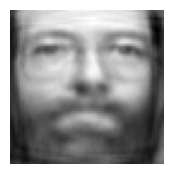

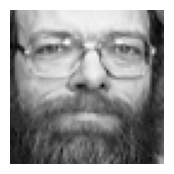

In [23]:
idx = np.random.randint(0, len(X_aug) - 10)
show_face(pca.inverse_transform(X_aug_pca[idx]).reshape((64, 64)))
show_face(X_aug[idx])

Quizás ese 4% de diferencia sí sea importante después de todo, para ello hay que ver cómo se desempeñan los modelos

## 3. Modelo base

### 3.1 Linear SVM Classifier

Como modelo base usaré un clasificador de SMV lineal

#### 3.1.1 Datos originales

In [24]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.05, random_state=1234, dual=True, max_iter=10000)
svc.fit(X.reshape(-1, 4096), Y)

print("Train score: ", svc.score(X.reshape(-1, 4096), Y))
print("Validation score: ", svc.score(X_val.reshape(-1, 4096), Y_val))

Train score:  1.0
Validation score:  0.984375


Estos resultados son relativamente buenos, y corren en un tiempo razonable (~10s). Probemos usar la *data* aumentada a ver si da más información y un mejor desempeño.

#### 3.1.2 Augmented data

In [162]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.05, random_state=1234)
svc.fit(X_aug.reshape(-1, 4096), Y_aug)

print("Train score: ", svc.score(X_aug.reshape(-1, 4096), Y_aug))
print("Validation score: ", svc.score(X_val.reshape(-1, 4096), Y_val))

Train score:  0.999609375
Validation score:  0.921875


/home/michel/MLF_FACES/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Esta corrida demora ~1:30 minutos, no demasiado lento, pero se puede mejorar mucho reduciendo la dimensionalidad del problema:

##### PCA 99% de la varianza

In [25]:
pca = PCA(0.99) # Mantener el 99% de la varianza

X_aug_pca = pca.fit_transform(X_aug.reshape((-1, 4096))) # ~11s

In [26]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.05, max_iter=100000, random_state=1234)
svc.fit(X_aug_pca, Y_aug)

print("Train score: ", svc.score(X_aug_pca, Y_aug))
print("Validation score: ", svc.score(pca.transform(X_val.reshape(-1, 4096)), Y_val))

Train score:  0.999609375
Validation score:  0.96875


El modelo de esta forma tiene la dimensión reducida ~7 veces y el tiempo de entrenamiento (que fue ~3.6s) es ~25 veces más rápido. Además se encontró un mejor *score* (seguramente se podría encontrar un mejor *score* con los datos originales, solo que habría que probar con los hiperparámetros y es mucho más lento hacerlo así)

##### PCA 95% de la varianza

In [27]:
pca = PCA(0.95) # Mantener el 95% de la varianza

X_aug_pca = pca.fit_transform(X_aug.reshape((-1, 4096))) # ~11s

In [33]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=0.05, random_state=1234)
svc.fit(X_aug_pca, Y_aug)

print("Train score: ", svc.score(X_aug_pca, Y_aug))
print("Validation score: ", svc.score(pca.transform(X_val.reshape(-1, 4096)), Y_val))

Train score:  0.98828125
Validation score:  0.953125


Como se decía más arriba, manteniendo solo el 95% de la varianza se logra reducir la dimensión del problema 21 veces, mucho más que manteniendo el 99%. Sin embargo, el entrenamineto solo reduce su tiempo en la mitad relativo al PCA 99% y se obtiene un menor *score*. Aún así los scores obtenidos no son mejores que los scores usando solo los datos originales, quizás no es un buen *data augmentation* lo utilizado.

#### 3.1.3 Conclusiones parciales

- El *data augmentation* no está dando mejores resultados.
- Usar los datos aumentados sin reducir la dimensionalidad es demasiado lento.
- Usando PCA(0.99) da resultados mucho mejores que PCA(0.95) con poco costo extra de tiempo.

#### 3.1.4 *Fine Tuning*

##### Datos originales

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_grid = {
	'C': loguniform(1e-4, 1)
}

clf = RandomizedSearchCV( LinearSVC(random_state=1234, max_iter=10000), param_grid, n_iter=10, random_state=1234, n_jobs=-1)

clf.fit(X.reshape(-1, 4096), Y)

best_clf = clf.best_estimator_
best_clf

LinearSVC(C=0.030791800489830132, max_iter=10000, random_state=1234)

El mejor modelo fue `LinearSVC(C=0.030791800489830132, max_iter=10000, random_state=1234)`

In [26]:
print("Train score: ", best_clf.score(X.reshape(-1, 4096), Y))
print("Validation score: ", best_clf.score(X_val.reshape(-1, 4096), Y_val))

Train score:  1.0
Validation score:  0.984375


El los *scores* los mismos que para la prueba inicial.

Por curiosidad haré una inspección de la matriz de confusión para ver si ciertamente las equivacaciones estuvieron en las personas con gafas.

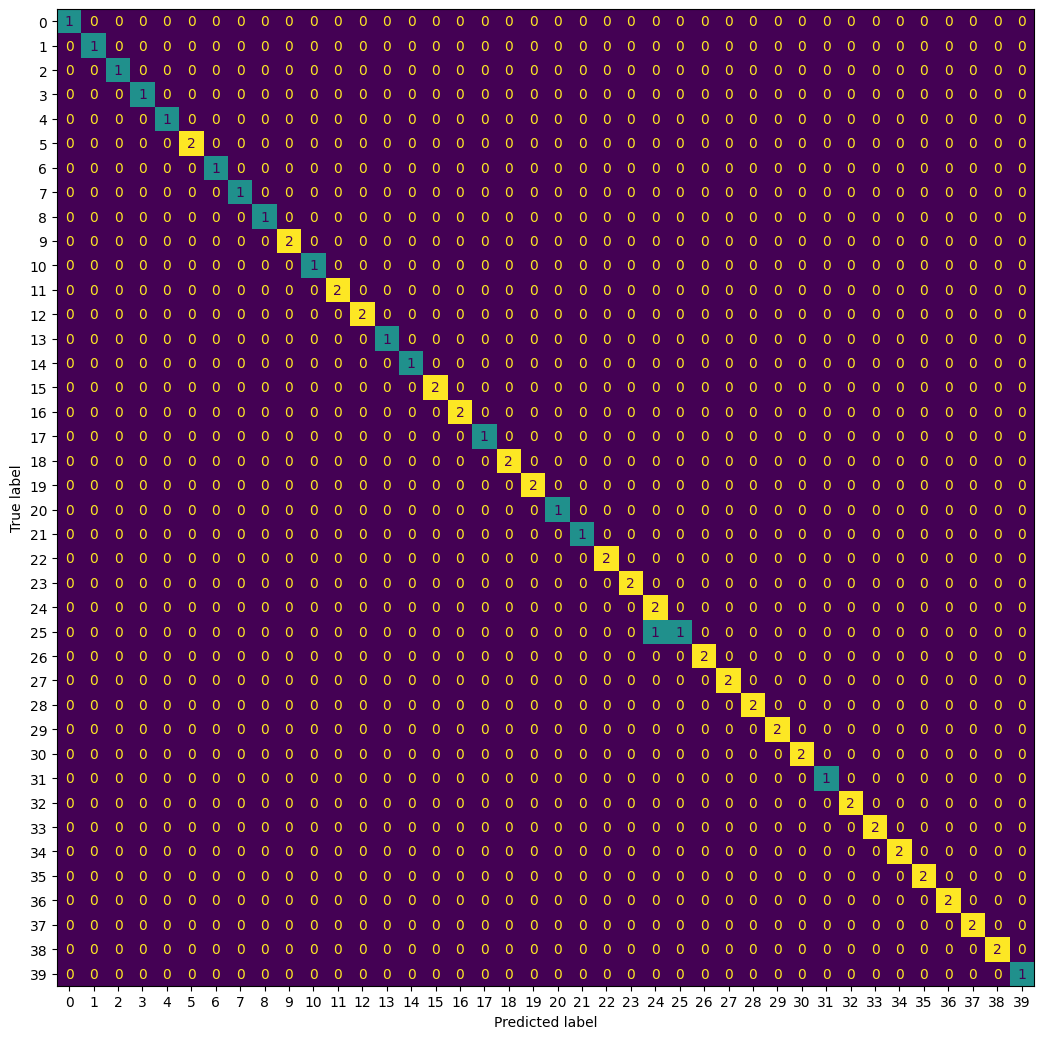

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_clf, X_val.reshape(-1, 4096), Y_val, include_values=True, colorbar=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.show()

La única confusión estuvo en una clasificación falsa de la clase 25 como clase 24, eso corresponde a las siguientes caras:

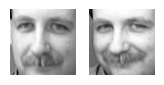

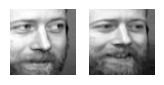

In [83]:
show_faces(X_val[Y_val == 24])
show_faces(X_val[Y_val == 25])

Pues no, no tuvo que ver nada con las gafas. Pero al menos ambos tienen bigote, quizás por ahí está la cosa

##### Exportar modelo

In [53]:
with open('models/linearSVC.pkl', 'wb') as f:
	pickle.dump(best_clf, f)

##### *Augmented* + PCA(0.99)

Para hacer *cross validation* en este caso crearé un *pipeline* con las transformaciones y el clasificador utilizados de modo que pueda aplicarse el CV correctamente sin contaminar las particiones de prueba.

In [59]:
class AugmentTransformer:
	'''
		Augment Tranformer for the pipeline

	Attributes
	==========

	aug: int
		Amount of augmented images for each original one
	'''
	def __init__(self, aug = 10, ang = 15, xshift = 5, yshift = 5):
		self.aug = aug
		self.random_transform = RandomTransform(ang, xshift, yshift)

	def fit(self, X, Y):
		return self

	def transform(self, X, Y):
		X_aug = []
		Y_aug = []

		for x, y in zip(X, Y):
			X_aug.append(x)
			Y_aug.append(y)
			for i in range(9):
				X_aug.append(self.random_transform(x))
				Y_aug.append(y)

		X_aug = np.array(X_aug)
		Y_aug = np.array(Y_aug)

		return X_aug, Y_aug

In [60]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
	('aug', AugmentTransformer()),
	('pca', PCA(0.99)),
	('svc', LinearSVC())
])

In [61]:
pipeline.fit(X, Y)

TypeError: transform() missing 1 required positional argument: 'Y'

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; width: 95%; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;">
<b>Error</b>: 
<p>
	Desafortunadamente <code>sklearn.pipeline.Pipeline</code> no aplica las transformaciones al target, solo a las variable independientes, y no es lo que se quiere para realizar el <em>data augmentation</em>.
</p>
</div>

De todas formas, el modelo tiene solo un parámetro que se ha visto que mejore su *performance* y se pudo acomodar a mano para obtener el resultado que se presentó antes

```
Train score:  0.999609375
Validation score:  0.96875
```

### 3.2 SVM Classifier

Probaré ahora con un SVC con un *kernel* no lineal

#### 3.2.1 Datos originales

In [63]:
from sklearn.svm import SVC

svc = SVC(C=10, random_state=1234)

svc.fit(X.reshape(-1, 4096), Y)

print("Train score: ", svc.score(X.reshape(-1, 4096), Y))
print("Validation score: ", svc.score(X_val.reshape(-1, 4096), Y_val))

Train score:  1.0
Validation score:  0.96875


##### *Fine tuning*

In [67]:
param_grid = {
    'C': loguniform(1e3, 1e5),
    'gamma': loguniform(1e-4, 1e-1),
		'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
		'degree': [3, 4, 5, 6]
}

clf = RandomizedSearchCV(SVC(random_state=1234), param_grid, n_iter=1000, random_state=1234, n_jobs=-1)

clf.fit(X.reshape(-1, 4096), Y)

best_svc = clf.best_estimator_
best_svc

SVC(C=2439.1436616050846, degree=4, gamma=0.0012613607997306727,
    random_state=1234)

In [68]:
print("Train score: ", best_svc.score(X.reshape(-1, 4096), Y))
print("Validation score: ", best_svc.score(X_val.reshape(-1, 4096), Y_val))

Train score:  1.0
Validation score:  0.96875


Estos resultados no son tan buenos como los obtenidos con anteriormente, me quedaré con los anteriores.

### 3.3 Conclusiones

- Se ajustó un modelo de `LinearSVC` con los datos originales y con datos aumentados con dimensión reducida
- El desempeño de ajustar los datos originales fue mejor que el de ajustar los datos aumentados con dimensión reducida

Quizás se podría obtener un desepmeño incluso mejor con datos aumentados sin reducción de dimensión, pero me conformo con los resultados obtenidos con el modelo aplicado a los datos originales.

Ya decidido que me quedaré con el mejor ajuste de `LinearSVC` probaré los scores con la partición de test:

Test score:  0.9875


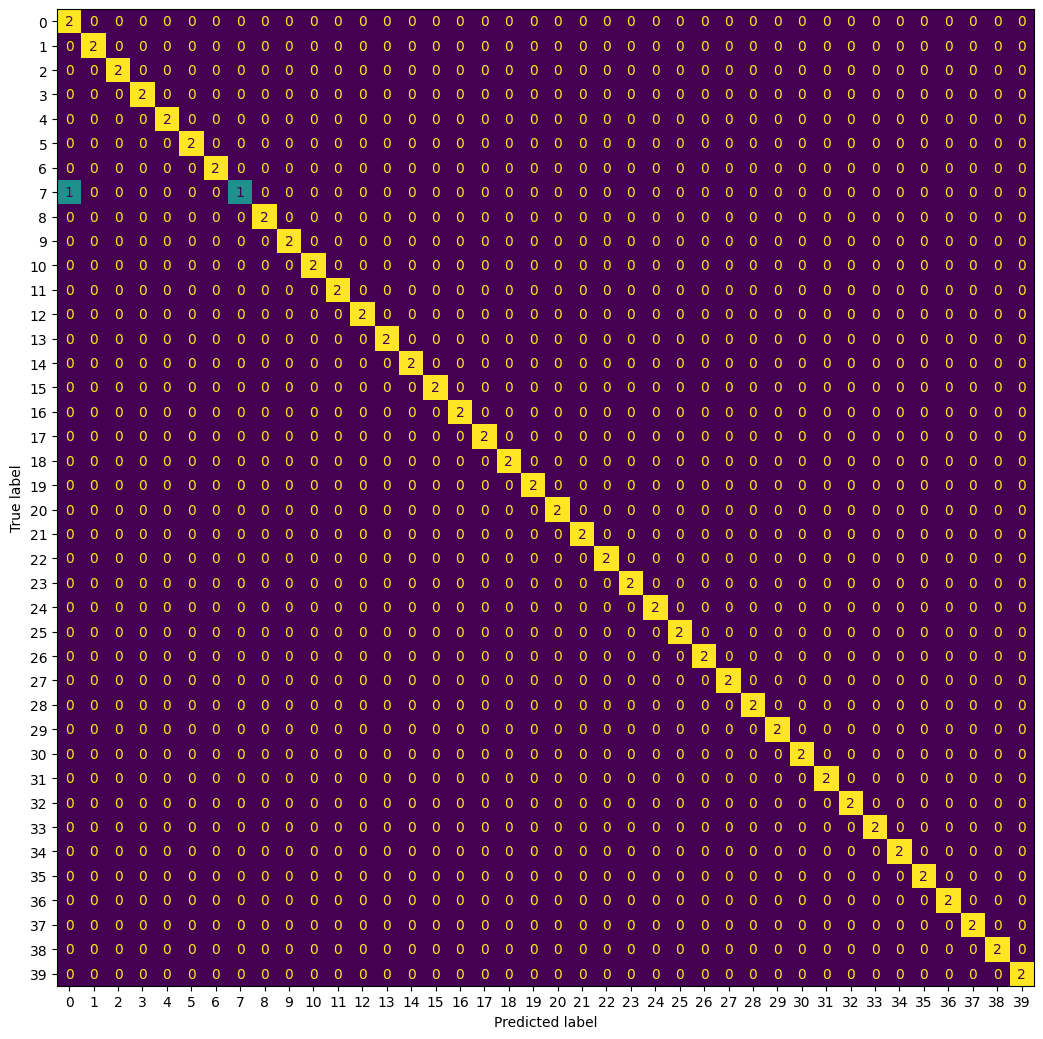

In [70]:
print("Test score: ", best_clf.score(X_test.reshape(-1, 4096), Y_test))

ConfusionMatrixDisplay.from_estimator(best_clf, X_test.reshape(-1, 4096), Y_test, include_values=True, colorbar=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.show()

El resultado es similar al resultado con la partición de validación, veamos qué caras se confundieron

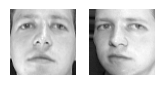

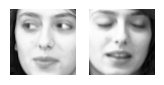

In [74]:
show_faces(X_test[Y_test == 0])
show_faces(X_test[Y_test == 7])

## 4. CNN *classifier*

### 4.1 Primer intento

De primera intentaré usar una red basada en la utilizada en [este artículo](https://towardsdatascience.com/build-your-first-image-classifier-with-convolution-neural-network-cnn-b4e9034ec5cb) en que se clasifican las imágenes del MNIST

<div align='center'>
	<img title="CNN1" alt="CNN" src="https://miro.medium.com/max/720/1*E1TP6FZs3kZuKnGAJezbjg.png">
</div>

#### 4.1.1 Preparación del modelo

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Model, Sequential

input_shape = (64, 64, 1)

# Definir el modelo
def create_first_model() -> Sequential:
	model = Sequential([
		Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
		MaxPool2D(pool_size=2),

		Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
		MaxPool2D(pool_size=2),

		Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
		MaxPool2D(pool_size=2),

		Flatten(),
		Dense(units=128, activation='relu'),
		Dense(units=40, activation='softmax'),
	])

	return model

#### 4.1.2 Preparación de los datos

Hay que cambiar las *shape* de las imágenes para que contengan la dimensión del canal. Además el *target* está representado como un valor numérico pero lo espera codificado con *One-hot* en forma de arreglos de 0s y un 1.

In [29]:
# Reshape X to input_shape
X_4_cnn = X.reshape(-1, *input_shape)
X_val_4_cnn = X_val.reshape(-1, *input_shape)

# One-hot-encode Y
Y_4_cnn = np.eye(40)[Y]
Y_val_4_cnn = np.eye(40)[Y_val]

In [37]:
# Compilar el modelo
cnn = create_first_model()
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### 4.1.3 Entrenamiento

Fui cambiando el `batch_size` (en potencias de 2) hasta que vi que demorara la menor cantidad de tiempo, al final resultó ser el valor por defecto el mejor. Puse una cantidad grande de epochs aunque vi que ya parecía haber llegado a un estacionario desde antes para probar el consejo de Karpathy de *leave it training*, pero no mejoró nada.

In [31]:
history = cnn.fit(X_4_cnn, Y_4_cnn, validation_data=(X_val_4_cnn, Y_val_4_cnn), batch_size=32, epochs=300, workers=8, verbose=1)
cnn.save('models/cnn1.model')

Epoch 1/300
8/8 [==============================] - 1s 54ms/step - loss: 0.3915 - accuracy: 0.0273 - val_loss: 0.2068 - val_accuracy: 0.0312
Epoch 2/300
8/8 [==============================] - 0s 40ms/step - loss: 0.1784 - accuracy: 0.0195 - val_loss: 0.1471 - val_accuracy: 0.0156
Epoch 3/300
8/8 [==============================] - 0s 41ms/step - loss: 0.1353 - accuracy: 0.0195 - val_loss: 0.1288 - val_accuracy: 0.0312
Epoch 4/300
8/8 [==============================] - 0s 44ms/step - loss: 0.1266 - accuracy: 0.0352 - val_loss: 0.1251 - val_accuracy: 0.0156
Epoch 5/300
8/8 [==============================] - 0s 43ms/step - loss: 0.1221 - accuracy: 0.0312 - val_loss: 0.1217 - val_accuracy: 0.0156
Epoch 6/300
8/8 [==============================] - 0s 42ms/step - loss: 0.1203 - accuracy: 0.0273 - val_loss: 0.1205 - val_accuracy: 0.0156
Epoch 7/300
8/8 [==============================] - 0s 43ms/step - loss: 0.1187 - accuracy: 0.0234 - val_loss: 0.1195 - val_accuracy: 0.0156
Epoch 8/300
8/8 [===

INFO:tensorflow:Assets written to: models/cnn1.model/assets


INFO:tensorflow:Assets written to: models/cnn1.model/assets


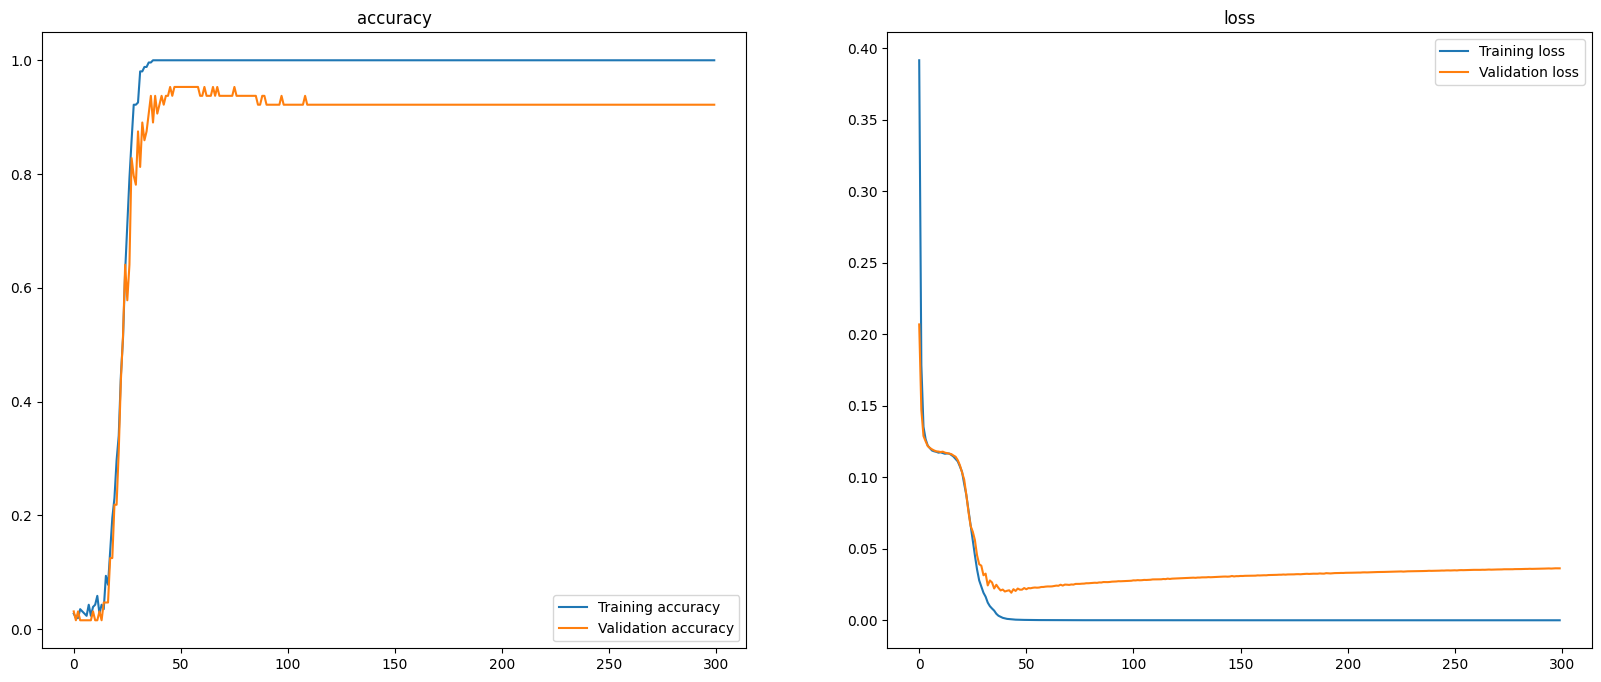

In [32]:
#model performance visualization
f = plt.figure(figsize=(20,8))

#accuracy
plt1 = f.add_subplot(121)
plt1.plot(history.history['accuracy'], label = str('Training accuracy'))
plt1.plot(history.history['val_accuracy'], label = str('Validation accuracy'))
plt.legend()
plt.title('accuracy')

#loss
plt2 = f.add_subplot(122)
plt2.plot(history.history['loss'], label = str('Training loss'))
plt2.plot(history.history['val_loss'], label = str('Validation loss'))
plt.legend()
plt.title('loss')

plt.show()

Probaré ahora cambiando la función de *loss* a `'categorical_crossentropy'` que en principio debería dar un mejor resultado

In [34]:
# Compilar el modelo
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_4_cnn, Y_4_cnn, validation_data=(X_val_4_cnn, Y_val_4_cnn), batch_size=32, epochs=300, workers=8, verbose=1)
cnn.save('models/cnn1_cat.model')

Epoch 1/300
8/8 [==============================] - 1s 52ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.5984 - val_accuracy: 0.9219
Epoch 2/300
8/8 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6110 - val_accuracy: 0.9219
Epoch 3/300
8/8 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6250 - val_accuracy: 0.9219
Epoch 4/300
8/8 [==============================] - 0s 42ms/step - loss: 4.6566e-10 - accuracy: 1.0000 - val_loss: 0.5995 - val_accuracy: 0.9219
Epoch 5/300
8/8 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.5693 - val_accuracy: 0.9219
Epoch 6/300
8/8 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.5794 - val_accuracy: 0.9219
Epoch 7/300
8/8 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.6006 - val_accuracy:

INFO:tensorflow:Assets written to: models/cnn1_cat.model/assets


INFO:tensorflow:Assets written to: models/cnn1_cat.model/assets


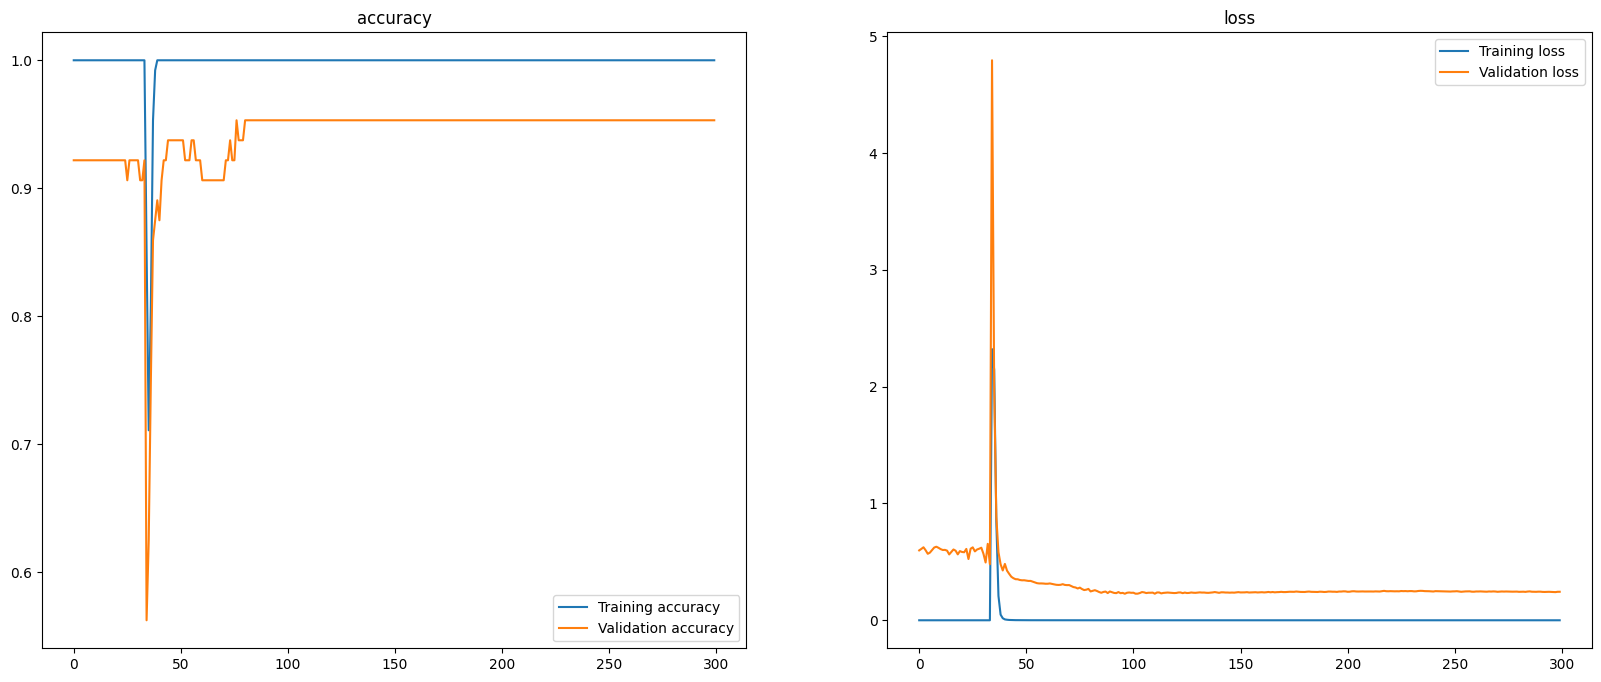

In [35]:
#model performance visualization
f = plt.figure(figsize=(20,8))

#accuracy
plt1 = f.add_subplot(121)
plt1.plot(history.history['accuracy'], label = str('Training accuracy'))
plt1.plot(history.history['val_accuracy'], label = str('Validation accuracy'))
plt.legend()
plt.title('accuracy')

#loss
plt2 = f.add_subplot(122)
plt2.plot(history.history['loss'], label = str('Training loss'))
plt2.plot(history.history['val_loss'], label = str('Validation loss'))
plt.legend()
plt.title('loss')

plt.show()

Los resultados son similares, ninguna venteja.

#### 4.1.4 Conclusiones

La CNN propuesta llega a valores de *accuracy* del orden de 0.95 en ~100 *epochs* y después no mejora. Este resultado es peor que el modelo base obtenido con métodos clásicos de *machine learning*.

### 4.2 Datos aumentados

Utilizando la misma arquitectura anterior probaré enternar la red con los datos sumentados en la sección 2.

In [54]:
cnn_aug = create_first_model()
cnn_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Hay que transformar los datos aumentados

In [55]:
# Reshape X to input_shape
X_aug_4_cnn = X_aug.reshape(-1, *input_shape)
X_val_4_cnn = X_val.reshape(-1, *input_shape)

# One-hot-encode Y
Y_aug_4_cnn = np.eye(40)[Y_aug]
Y_val_4_cnn = np.eye(40)[Y_val]

Agregaré un callback de detenimiento temprano para evitar el *overfitting* y además recuperar el mejor de los conjuntos de pesos de la red.

In [56]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(1234)

early_stop = EarlyStopping(
	monitor='val_loss',
	patience=10,
	restore_best_weights=True # Restore the best wheights after stop
)

history = cnn_aug.fit(X_aug_4_cnn, Y_aug_4_cnn, validation_data=(X_val_4_cnn, Y_val_4_cnn), callbacks=[early_stop], batch_size=32, epochs=1000, workers=8, verbose=1)
cnn.save('models/cnn1_aug.model')

Epoch 1/1000
80/80 [==============================] - 3s 39ms/step - loss: 0.1520 - accuracy: 0.0293 - val_loss: 0.1193 - val_accuracy: 0.0156
Epoch 2/1000
80/80 [==============================] - 3s 38ms/step - loss: 0.1186 - accuracy: 0.0227 - val_loss: 0.1184 - val_accuracy: 0.0312
Epoch 3/1000
80/80 [==============================] - 3s 39ms/step - loss: 0.1180 - accuracy: 0.0301 - val_loss: 0.1176 - val_accuracy: 0.0469
Epoch 4/1000
80/80 [==============================] - 3s 39ms/step - loss: 0.1145 - accuracy: 0.0770 - val_loss: 0.1049 - val_accuracy: 0.1875
Epoch 5/1000
80/80 [==============================] - 3s 39ms/step - loss: 0.0856 - accuracy: 0.3523 - val_loss: 0.0552 - val_accuracy: 0.6406
Epoch 6/1000
80/80 [==============================] - 3s 39ms/step - loss: 0.0501 - accuracy: 0.6977 - val_loss: 0.0275 - val_accuracy: 0.8906
Epoch 7/1000
80/80 [==============================] - 3s 39ms/step - loss: 0.0299 - accuracy: 0.8512 - val_loss: 0.0153 - val_accuracy: 0.9688

INFO:tensorflow:Assets written to: models/cnn1_aug.model/assets


INFO:tensorflow:Assets written to: models/cnn1_aug.model/assets


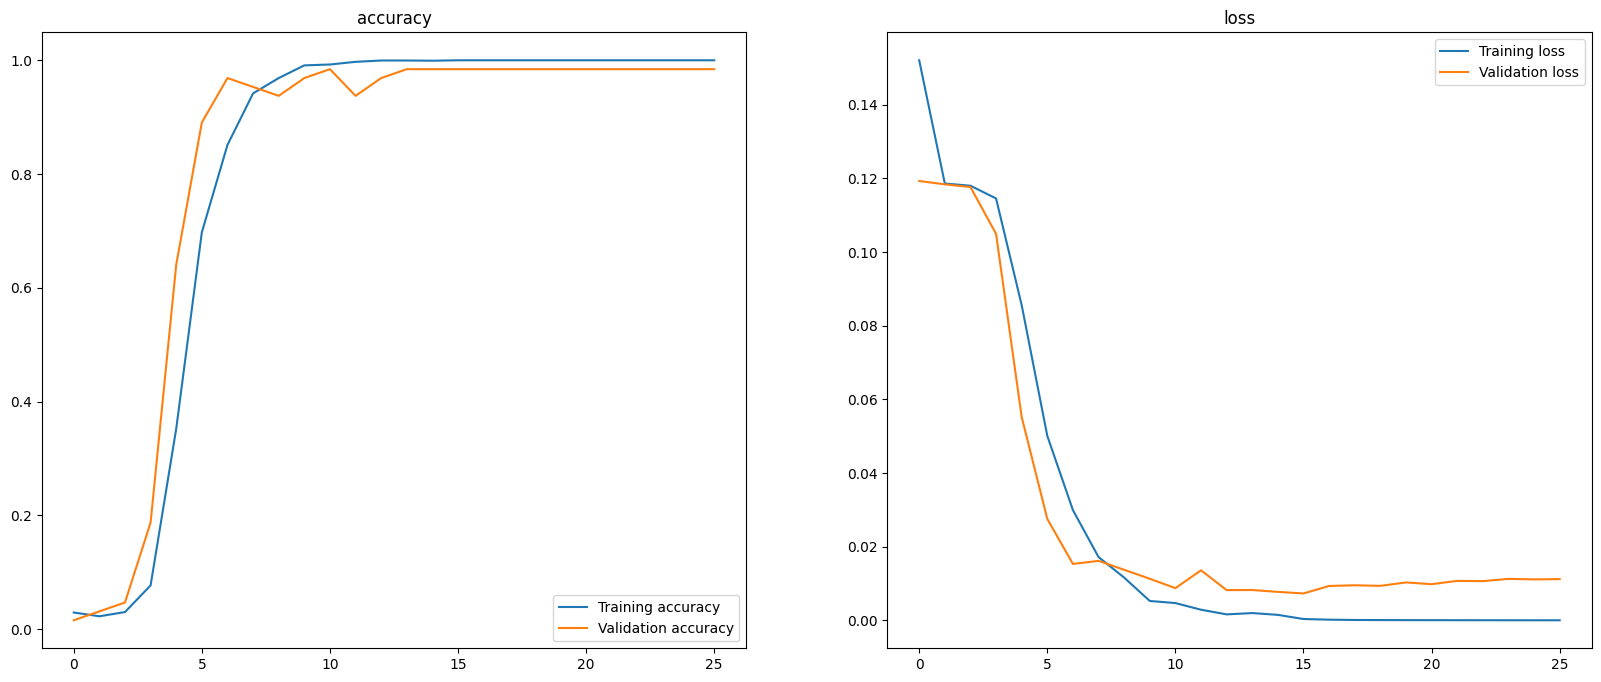

In [57]:
#model performance visualization
f = plt.figure(figsize=(20,8))

#accuracy
plt1 = f.add_subplot(121)
plt1.plot(history.history['accuracy'], label = str('Training accuracy'))
plt1.plot(history.history['val_accuracy'], label = str('Validation accuracy'))
plt.legend()
plt.title('accuracy')

#loss
plt2 = f.add_subplot(122)
plt2.plot(history.history['loss'], label = str('Training loss'))
plt2.plot(history.history['val_loss'], label = str('Validation loss'))
plt.legend()
plt.title('loss')

plt.show()

El accuracy de la validación en este modelo es muy cercano al obtenido con el modelo de base clásico, probemos aumentar aún más los datos.

#### 4.2.1 Datos aún más aumentados

In [52]:
# Transformación random
random_transform = RandomTransform(15, 5, 5)

X_emaug = [] # (e)ven (m)ore (aug)mented
Y_emaug = []

for x, y in zip(X, Y):
	X_emaug.append(x)
	Y_emaug.append(y)
	for i in range(19):
		X_emaug.append(random_transform(x))
		Y_emaug.append(y)

X_emaug = np.array(X_emaug)
Y_emaug = np.array(Y_emaug)

In [59]:
cnn_emaug = create_first_model()
cnn_emaug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape X to input_shape
X_emaug_4_cnn = X_emaug.reshape(-1, *input_shape)
X_val_4_cnn = X_val.reshape(-1, *input_shape)

# One-hot-encode Y
Y_emaug_4_cnn = np.eye(40)[Y_emaug]
Y_val_4_cnn = np.eye(40)[Y_val]

In [60]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(1234)

early_stop = EarlyStopping(
	monitor='val_loss',
	patience=10,
	restore_best_weights=True # Restore the best wheights after stop
)

history = cnn_emaug.fit(X_emaug_4_cnn, Y_emaug_4_cnn, validation_data=(X_val_4_cnn, Y_val_4_cnn), callbacks=[early_stop], batch_size=32, epochs=1000, workers=8, verbose=1)
cnn.save('models/cnn1_emaug.model')

Epoch 1/1000
160/160 [==============================] - 7s 39ms/step - loss: 0.1365 - accuracy: 0.0332 - val_loss: 0.1191 - val_accuracy: 0.0312
Epoch 2/1000
160/160 [==============================] - 6s 38ms/step - loss: 0.1129 - accuracy: 0.0850 - val_loss: 0.0925 - val_accuracy: 0.3594
Epoch 3/1000
160/160 [==============================] - 6s 39ms/step - loss: 0.0592 - accuracy: 0.5996 - val_loss: 0.0293 - val_accuracy: 0.8750
Epoch 4/1000
160/160 [==============================] - 6s 39ms/step - loss: 0.0208 - accuracy: 0.9182 - val_loss: 0.0121 - val_accuracy: 0.9844
Epoch 5/1000
160/160 [==============================] - 6s 39ms/step - loss: 0.0083 - accuracy: 0.9834 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 6/1000
160/160 [==============================] - 6s 39ms/step - loss: 0.0050 - accuracy: 0.9934 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 7/1000
160/160 [==============================] - 6s 38ms/step - loss: 0.0032 - accuracy: 0.9971 - val_loss: 0.0051 - val_ac

INFO:tensorflow:Assets written to: models/cnn1_emaug.model/assets


INFO:tensorflow:Assets written to: models/cnn1_emaug.model/assets


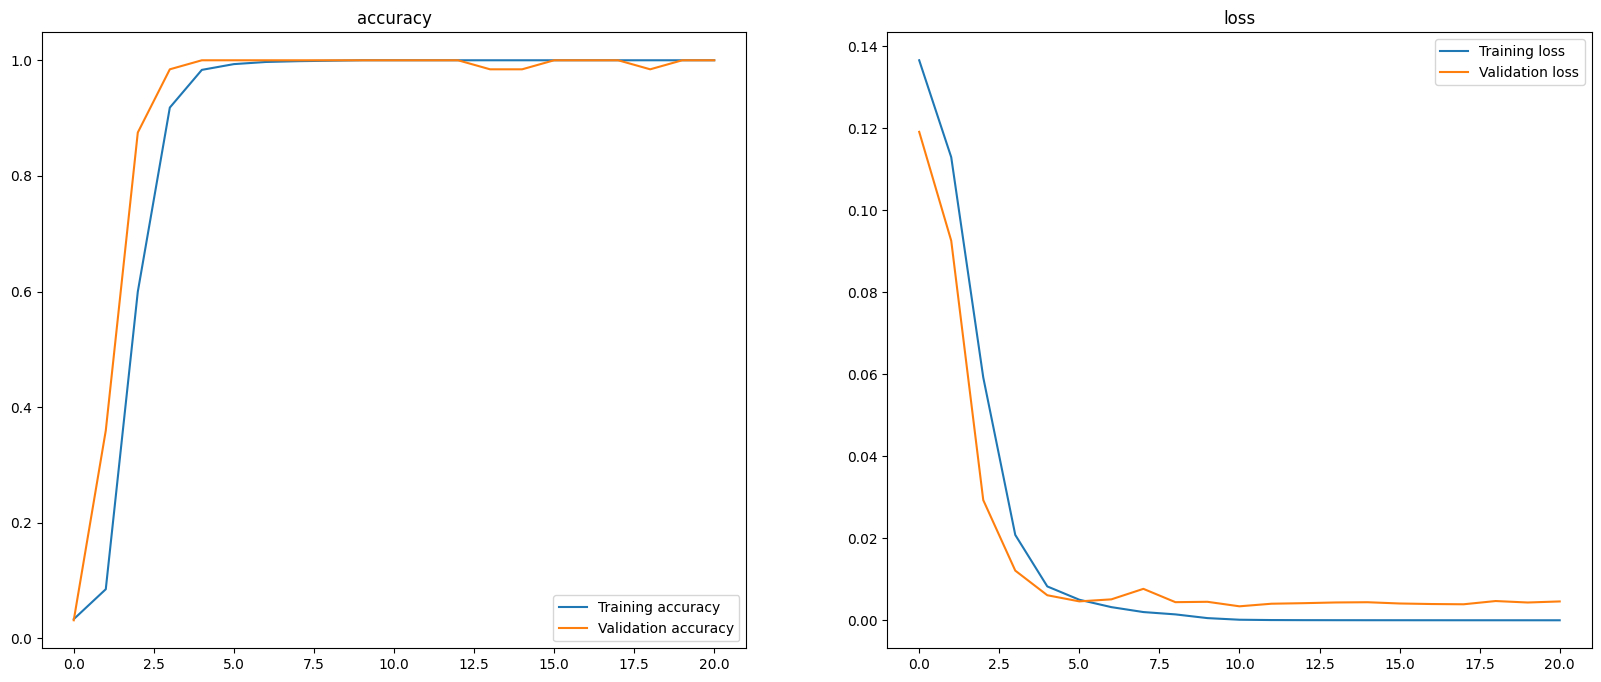

In [61]:
#model performance visualization
f = plt.figure(figsize=(20,8))

#accuracy
plt1 = f.add_subplot(121)
plt1.plot(history.history['accuracy'], label = str('Training accuracy'))
plt1.plot(history.history['val_accuracy'], label = str('Validation accuracy'))
plt.legend()
plt.title('accuracy')

#loss
plt2 = f.add_subplot(122)
plt2.plot(history.history['loss'], label = str('Training loss'))
plt2.plot(history.history['val_loss'], label = str('Validation loss'))
plt.legend()
plt.title('loss')

plt.show()

¡Genial! Este modelo tiene un accuracy de 100%. Esto en realidad puede ser por la proporción tan pequeña de validación que tengo, hay que probar con la partición de prueba cómo queda el asunto, pero hasta ahora este último es el mejor resultado.

### 4.3 Evaluación de *test*

Primero manipulemos la partición de prueba para poder evaluarla con la CNN

In [64]:
# Reshape X to input_shape
X_test_4_cnn = X_test.reshape(-1, *input_shape)

# One-hot-encode Y
Y_test_4_cnn = np.eye(40)[Y_test]

Ahora busco evalúo las métricas obtenidas y ploteo la matriz de confusión

{'loss': 0.004640948958694935, 'accuracy': 0.987500011920929}


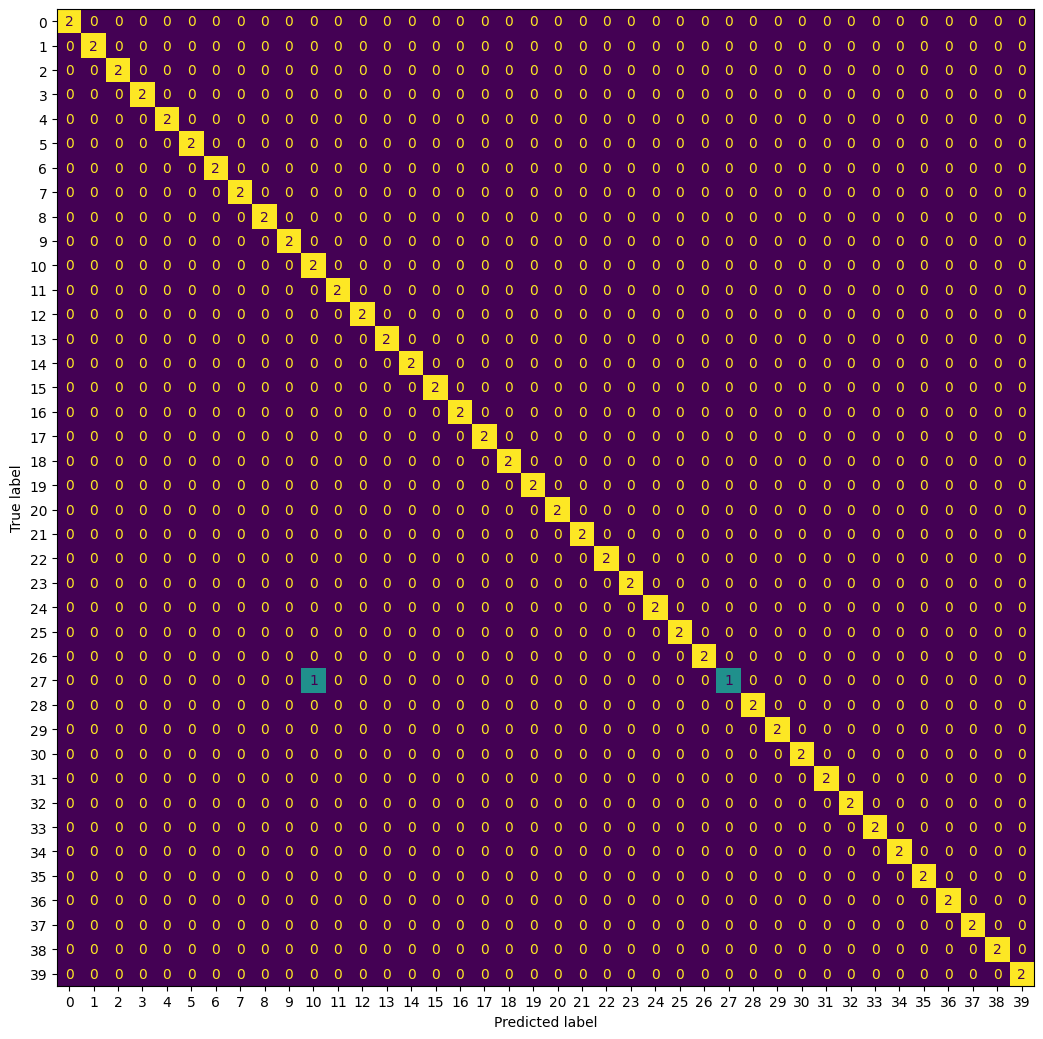

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

print(cnn_emaug.evaluate(X_test_4_cnn, Y_test_4_cnn, return_dict=True, verbose=0))

y_pred = cnn_emaug.predict(X_test_4_cnn, verbose=0)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred.argmax(axis=1), include_values=True, colorbar=False)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.show()

Esta vez la cara mal clasificada es la 27, clasificada erróneamente como 10

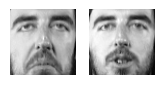

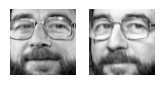

In [82]:
show_faces(X_test[Y_test == 10])
show_faces(X_test[Y_test == 27])

🤔 Ciertamente se parecen, no está tan mal 

## 5. Conclusiones

A partir de los datos se construyeron dos algoritmos de clasificación, uno basado en SVM lineal y otro con una red neuronal convolucional, tratando el primero como un *baseline*.

Después de hacer varias manipulaciones se concluyó que el modelo base podía enternarse con los datos originales pues el ajuste era relativamente rápido y los resultados buenos.

Luego, con la CNN fue necesario hacer manipulación para aumentar la cantidad de datos y de esta manera se logró obtener un modelo con un desempeño igual al modelo base. 
